## Mental Health Status and Sentiment Analysis

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot  as plt

import warnings
warnings.filterwarnings('ignore')

from wordcloud import WordCloud
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


In [2]:
# path=r
df = pd.read_csv('../data/data.csv', index_col=0)
df.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [4]:
df.isnull().sum()

statement    362
status         0
dtype: int64

In [5]:
df.dropna(inplace = True)

In [6]:
df.describe()

,statement,status
count,52681,52681
unique,51073,7
top,what do you mean?,Normal
freq,22,16343


## EDA

In [7]:
statuses = df['status'].unique()
statuses

array(['Anxiety', 'Normal', 'Depression', 'Suicidal', 'Stress', 'Bipolar',
       'Personality disorder'], dtype=object)

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'Anxiety'),
  Text(1, 0, 'Normal'),
  Text(2, 0, 'Depression'),
  Text(3, 0, 'Suicidal'),
  Text(4, 0, 'Stress'),
  Text(5, 0, 'Bipolar'),
  Text(6, 0, 'Personality disorder')])

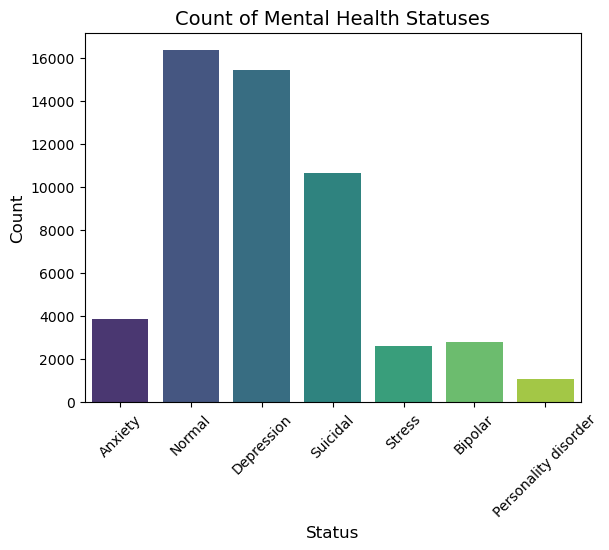

In [8]:
sns.countplot(data=df, x='status', palette='viridis')
plt.title('Count of Mental Health Statuses', fontsize=14)
plt.xlabel('Status', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)


In [9]:
df['statement_word_len'] = df['statement'].apply(lambda x: len(x.split(' ')))
df.head()

,statement,status,statement_word_len
0,oh my gosh,Anxiety,3
1,"trouble sleeping, confused mind, restless hear...",Anxiety,10
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,14
3,I've shifted my focus to something else but I'...,Anxiety,11
4,"I'm restless and restless, it's been a month n...",Anxiety,14


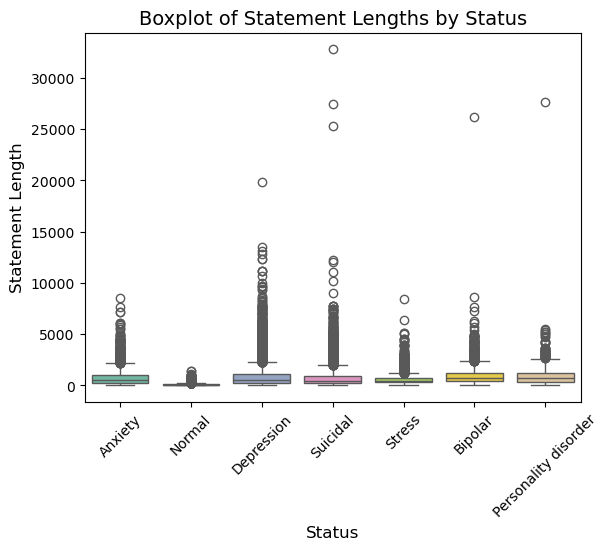

In [10]:
df['statement_length'] = df['statement'].apply(lambda x: len(str(x)))

sns.boxplot(data=df, x='status', y='statement_length', palette='Set2')
plt.title('Boxplot of Statement Lengths by Status', fontsize=14)
plt.xlabel('Status', fontsize=12)
plt.ylabel('Statement Length', fontsize=12)
plt.xticks(rotation=45)
plt.show()

## Wordcloud

In [11]:
# !pip install wordcloud

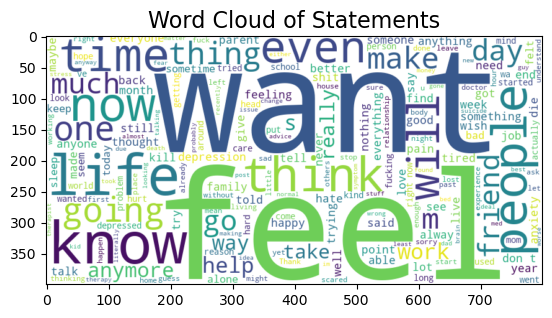

In [12]:
from wordcloud import WordCloud
text = " ".join(df['statement'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)

# plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
plt.title('Word Cloud of Statements', fontsize=16)
plt.show()

In [13]:
df

,statement,status,statement_word_len,statement_length
0,oh my gosh,Anxiety,3,10
1,"trouble sleeping, confused mind, restless hear...",Anxiety,10,64
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,14,78
3,I've shifted my focus to something else but I'...,Anxiety,11,61
4,"I'm restless and restless, it's been a month n...",Anxiety,14,72
...,...,...,...,...
53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety,322,1766
53039,"selfishness ""I don't feel very good, it's lik...",Anxiety,199,1012
53040,Is there any way to sleep better? I can't slee...,Anxiety,17,85
53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety,74,401


In [11]:
dfgrid=df.copy()

## pre-process

In [15]:
# Cleaning the corpus
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    
    text = str(text).lower() # Convert to string and lowercase
    
    text = re.sub(r'\[.*?\]', '', text) # Remove text in square brackets
    
    text = re.sub(r'https?://\S+|www\.\S+|\[.*?\]\(.*?\)', '', text) # Remove URLs
      
    text = re.sub(r'<.*?>+', '', text)# Remove tags
    
    text = re.sub(r'@\w+', '', text)# Remove @
    
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text) # Remove punctuation
    
    text = re.sub(r'\n', ' ', text) # Remove newline
      
    text = re.sub(r'\w*\d\w*', '', text)# Remove words with numbers
      
    text = re.sub(r'\s+', ' ', text)# Remove spaces
    
    return text.strip()

In [16]:
df1 = df.copy()

df1['statement_clean'] = df1['statement'].apply(clean_text)
df1.head()

,statement,status,statement_word_len,statement_length,statement_clean
0,oh my gosh,Anxiety,3,10,oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,10,64,trouble sleeping confused mind restless heart ...
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,14,78,all wrong back off dear forward doubt stay in ...
3,I've shifted my focus to something else but I'...,Anxiety,11,61,ive shifted my focus to something else but im ...
4,"I'm restless and restless, it's been a month n...",Anxiety,14,72,im restless and restless its been a month now ...


In [17]:
stop_words = stopwords.words('english') 
# more_stopwords = ['u', 'im', 'c']
# stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text
    
df1['stop_word_statement'] = df1['statement_clean'].apply(remove_stopwords)
df1.head()

,statement,status,statement_word_len,statement_length,statement_clean,stop_word_statement
0,oh my gosh,Anxiety,3,10,oh my gosh,oh gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,10,64,trouble sleeping confused mind restless heart ...,trouble sleeping confused mind restless heart ...
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,14,78,all wrong back off dear forward doubt stay in ...,wrong back dear forward doubt stay restless re...
3,I've shifted my focus to something else but I'...,Anxiety,11,61,ive shifted my focus to something else but im ...,ive shifted focus something else im still worried
4,"I'm restless and restless, it's been a month n...",Anxiety,14,72,im restless and restless its been a month now ...,im restless restless month boy mean


In [18]:
 
# stemmer = nltk.PorterStemmer()

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

df1['stemmer_statement'] = df1['statement_clean'].apply(stemm_text) 
df1.head()

,statement,status,statement_word_len,statement_length,statement_clean,stop_word_statement,stemmer_statement
0,oh my gosh,Anxiety,3,10,oh my gosh,oh gosh,oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,10,64,trouble sleeping confused mind restless heart ...,trouble sleeping confused mind restless heart ...,troubl sleep confus mind restless heart all ou...
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,14,78,all wrong back off dear forward doubt stay in ...,wrong back dear forward doubt stay restless re...,all wrong back off dear forward doubt stay in ...
3,I've shifted my focus to something else but I'...,Anxiety,11,61,ive shifted my focus to something else but im ...,ive shifted focus something else im still worried,ive shift my focus to someth els but im still ...
4,"I'm restless and restless, it's been a month n...",Anxiety,14,72,im restless and restless its been a month now ...,im restless restless month boy mean,im restless and restless it been a month now b...


In [19]:
nltk.download('punkt')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split(' '))
    return text

df1['lemmatizer_statement'] = df1['statement_clean'].apply(lemmatize_text)
df1.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sudwa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sudwa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,statement,status,statement_word_len,statement_length,statement_clean,stop_word_statement,stemmer_statement,lemmatizer_statement
0,oh my gosh,Anxiety,3,10,oh my gosh,oh gosh,oh my gosh,oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,10,64,trouble sleeping confused mind restless heart ...,trouble sleeping confused mind restless heart ...,troubl sleep confus mind restless heart all ou...,trouble sleeping confused mind restless heart ...
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,14,78,all wrong back off dear forward doubt stay in ...,wrong back dear forward doubt stay restless re...,all wrong back off dear forward doubt stay in ...,all wrong back off dear forward doubt stay in ...
3,I've shifted my focus to something else but I'...,Anxiety,11,61,ive shifted my focus to something else but im ...,ive shifted focus something else im still worried,ive shift my focus to someth els but im still ...,ive shifted my focus to something else but im ...
4,"I'm restless and restless, it's been a month n...",Anxiety,14,72,im restless and restless its been a month now ...,im restless restless month boy mean,im restless and restless it been a month now b...,im restless and restless it been a month now b...


In [20]:
#function

def preprocess_data(text):
    #Clean test
    text = clean_text(text)
    # Remove stopwords
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    # Stemm all the words in the sentence
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    
    return text

df1['preprocess_data'] = df1['statement'].apply(preprocess_data)
df1.head()

,statement,status,statement_word_len,statement_length,statement_clean,stop_word_statement,stemmer_statement,lemmatizer_statement,preprocess_data
0,oh my gosh,Anxiety,3,10,oh my gosh,oh gosh,oh my gosh,oh my gosh,oh gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,10,64,trouble sleeping confused mind restless heart ...,trouble sleeping confused mind restless heart ...,troubl sleep confus mind restless heart all ou...,trouble sleeping confused mind restless heart ...,troubl sleep confus mind restless heart tune
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,14,78,all wrong back off dear forward doubt stay in ...,wrong back dear forward doubt stay restless re...,all wrong back off dear forward doubt stay in ...,all wrong back off dear forward doubt stay in ...,wrong back dear forward doubt stay restless re...
3,I've shifted my focus to something else but I'...,Anxiety,11,61,ive shifted my focus to something else but im ...,ive shifted focus something else im still worried,ive shift my focus to someth els but im still ...,ive shifted my focus to something else but im ...,ive shift focus someth els im still worri
4,"I'm restless and restless, it's been a month n...",Anxiety,14,72,im restless and restless its been a month now ...,im restless restless month boy mean,im restless and restless it been a month now b...,im restless and restless it been a month now b...,im restless restless month boy mean


In [21]:
from sklearn.preprocessing import LabelEncoder

df2=df1.copy()

encoder = LabelEncoder()
df2['status_encoded'] = encoder.fit_transform(df2['status']) 
df2.head()

,statement,status,statement_word_len,statement_length,statement_clean,stop_word_statement,stemmer_statement,lemmatizer_statement,preprocess_data,status_encoded
0,oh my gosh,Anxiety,3,10,oh my gosh,oh gosh,oh my gosh,oh my gosh,oh gosh,0
1,"trouble sleeping, confused mind, restless hear...",Anxiety,10,64,trouble sleeping confused mind restless heart ...,trouble sleeping confused mind restless heart ...,troubl sleep confus mind restless heart all ou...,trouble sleeping confused mind restless heart ...,troubl sleep confus mind restless heart tune,0
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,14,78,all wrong back off dear forward doubt stay in ...,wrong back dear forward doubt stay restless re...,all wrong back off dear forward doubt stay in ...,all wrong back off dear forward doubt stay in ...,wrong back dear forward doubt stay restless re...,0
3,I've shifted my focus to something else but I'...,Anxiety,11,61,ive shifted my focus to something else but im ...,ive shifted focus something else im still worried,ive shift my focus to someth els but im still ...,ive shifted my focus to something else but im ...,ive shift focus someth els im still worri,0
4,"I'm restless and restless, it's been a month n...",Anxiety,14,72,im restless and restless its been a month now ...,im restless restless month boy mean,im restless and restless it been a month now b...,im restless and restless it been a month now b...,im restless restless month boy mean,0


In [22]:
from sklearn.model_selection import train_test_split

X = df2['preprocess_data']  # Feature: Text data
y = df2['status']  # Target: Encoded labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [23]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Sample data
documents = ["I love machine learning", "I love deep learning"]

# Using CountVectorizer
count_vectorizer = CountVectorizer()
count_vectors = count_vectorizer.fit_transform(documents)
print("CountVectorizer Results:")
print(count_vectors.toarray())  # Display word count matrix

# Using TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectors = tfidf_vectorizer.fit_transform(documents)
print("\nTfidfVectorizer Results:")
print(tfidf_vectors.toarray())  # Display tf-idf matrix


CountVectorizer Results:
[[0 1 1 1]
 [1 1 1 0]]

TfidfVectorizer Results:
[[0.         0.50154891 0.50154891 0.70490949]
 [0.70490949 0.50154891 0.50154891 0.        ]]


In [24]:


count_vector = CountVectorizer(stop_words='english', ngram_range=(1,2), max_df=0.7, max_features=5000)
# count_vector.fit(X_train)

X_train_cv = count_vector.fit_transform(X_train)
X_test_cv = count_vector.transform(X_test)

tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

Accuracy:  0.7496441112271045
                      precision    recall  f1-score   support

             Anxiety       0.82      0.73      0.77       768
             Bipolar       0.85      0.72      0.78       556
          Depression       0.70      0.69      0.70      3081
              Normal       0.85      0.95      0.90      3269
Personality disorder       0.75      0.59      0.66       215
              Stress       0.58      0.50      0.53       517
            Suicidal       0.64      0.61      0.63      2131

            accuracy                           0.75     10537
           macro avg       0.74      0.69      0.71     10537
        weighted avg       0.74      0.75      0.75     10537



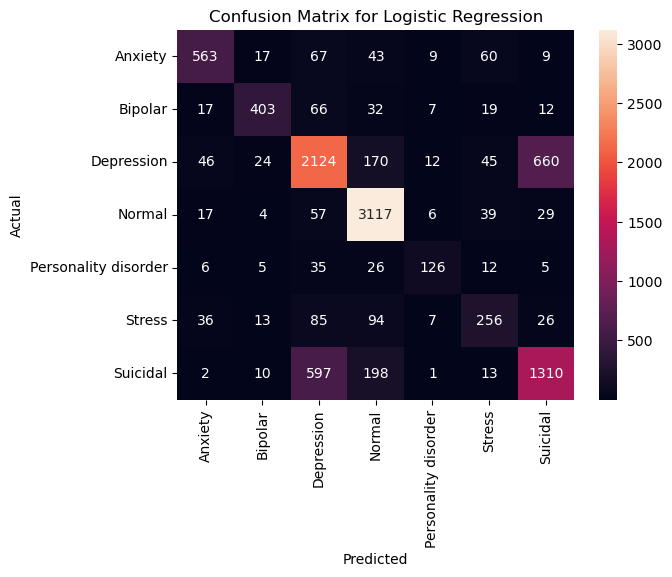

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

#using count_vector
logr = LogisticRegression(random_state= 42) 

# Train the classifier
logr.fit(X_train_cv, y_train)
y_pred = logr.predict(X_test_cv)
labels = encoder.classes_
acc = accuracy_score(y_test, y_pred)
print('Accuracy: ',acc)
conf_matrix = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred, target_names=labels))

sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

Accuracy:  0.7609376482869887
                      precision    recall  f1-score   support

             Anxiety       0.83      0.74      0.78       768
             Bipolar       0.89      0.68      0.77       556
          Depression       0.70      0.74      0.72      3081
              Normal       0.83      0.95      0.89      3269
Personality disorder       0.79      0.49      0.61       215
              Stress       0.67      0.44      0.53       517
            Suicidal       0.69      0.63      0.66      2131

            accuracy                           0.76     10537
           macro avg       0.77      0.67      0.71     10537
        weighted avg       0.76      0.76      0.76     10537



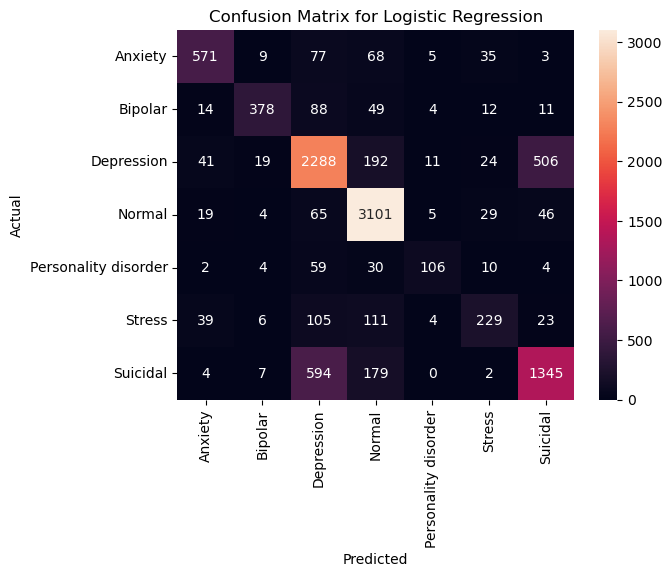

In [26]:
# using tfidf
logr = LogisticRegression(random_state= 42) 

# Train the classifier
logr.fit(X_train_tfidf, y_train)
y_pred = logr.predict(X_test_tfidf)
labels = encoder.classes_
acc = accuracy_score(y_test, y_pred)
print('Accuracy: ',acc)
conf_matrix = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred, target_names=labels))

sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

In [27]:
from imblearn.over_sampling import SMOTE, RandomOverSampler

sm = SMOTE() 
X_train_sm, y_train_sm = sm.fit_resample(X_train_tfidf, y_train)
print((X_train_sm.shape), (y_train_sm.shape))

(91518, 5000) (91518,)


Accuracy:  0.7257283856885262
                      precision    recall  f1-score   support

             Anxiety       0.69      0.81      0.74       768
             Bipolar       0.78      0.78      0.78       556
          Depression       0.76      0.63      0.69      3081
              Normal       0.90      0.81      0.85      3269
Personality disorder       0.45      0.73      0.55       215
              Stress       0.40      0.66      0.50       517
            Suicidal       0.63      0.71      0.67      2131

            accuracy                           0.73     10537
           macro avg       0.66      0.73      0.68     10537
        weighted avg       0.75      0.73      0.73     10537



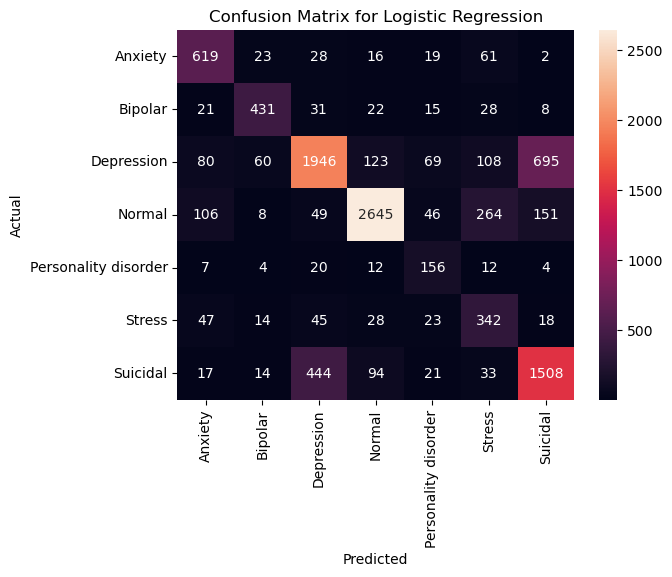

In [28]:
# using tfidf with smote
logr = LogisticRegression(random_state= 42) 

# Train the classifier
logr.fit(X_train_sm, y_train_sm)
y_pred = logr.predict(X_test_tfidf)
labels = encoder.classes_
acc = accuracy_score(y_test, y_pred)
print('Accuracy: ',acc)
conf_matrix = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred, target_names=labels))

sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

In [29]:
print(X_train_tfidf.shape,X_test_tfidf.shape, y_train.shape,y_test.shape)


(42144, 5000) (10537, 5000) (42144,) (10537,)


In [30]:
# !pip install lightgbm
# !pip install catboost

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

models = {
    "Logistic Regression": LogisticRegression(),
    "Naive Bayes": MultinomialNB(),
    # "Random Forest": RandomForestClassifier(),
    # "SVM": SVC(probability=True),
    # "GBC": GradientBoostingClassifier(),
    # "Tree":DecisionTreeClassifier(),
    # "XGBoost": XGBClassifier(use_label_encoder=True, eval_metric='logloss'),
    # "KNN":KNeighborsClassifier(),
    "LightGBM": LGBMClassifier(),
}

In [32]:
results = {}
for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))
    print("=" * 20)

Logistic Regression Accuracy: 0.7609
                      precision    recall  f1-score   support

             Anxiety       0.83      0.74      0.78       768
             Bipolar       0.89      0.68      0.77       556
          Depression       0.70      0.74      0.72      3081
              Normal       0.83      0.95      0.89      3269
Personality disorder       0.79      0.49      0.61       215
              Stress       0.67      0.44      0.53       517
            Suicidal       0.69      0.63      0.66      2131

            accuracy                           0.76     10537
           macro avg       0.77      0.67      0.71     10537
        weighted avg       0.76      0.76      0.76     10537

Naive Bayes Accuracy: 0.6550
                      precision    recall  f1-score   support

             Anxiety       0.78      0.60      0.68       768
             Bipolar       0.88      0.46      0.60       556
          Depression       0.50      0.81      0.62      3081


In [33]:
results_df = pd.DataFrame(results.items(), columns=['Model', 'Accuracy']).sort_values(by='Accuracy', ascending=False)
results_df

,Model,Accuracy
2,LightGBM,0.776407
0,Logistic Regression,0.760938
1,Naive Bayes,0.655025


In [23]:
dfgrid

,statement,status,statement_word_len,statement_length,clean
0,oh my gosh,Anxiety,3,10,oh gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,10,64,troubl sleep confus mind restless heart tune
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,14,78,wrong back dear forward doubt stay restless re...
3,I've shifted my focus to something else but I'...,Anxiety,11,61,ive shift focus someth els im still worri
4,"I'm restless and restless, it's been a month n...",Anxiety,14,72,im restless restless month boy mean
...,...,...,...,...,...
53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety,322,1766,nobodi take serious i'v dealt depressionanxiet...
53039,"selfishness ""I don't feel very good, it's lik...",Anxiety,199,1012,selfish dont feel good like dont belong world ...
53040,Is there any way to sleep better? I can't slee...,Anxiety,17,85,way sleep better cant sleep night med didnt help
53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety,74,401,public speak tip hi give present work next wee...


In [12]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.stem import WordNetLemmatizer
stemmer = nltk.SnowballStemmer("english")
stop_words = stopwords.words('english')
nltk.download('punkt')
nltk.download('wordnet')

def helper_text(text):
    text = str(text).lower()  # Convert to string and lowercase
    
    text = re.sub(r'\[.*?\]', '', text)  # Remove text in square brackets
    
    text = re.sub(r'https?://\S+|www\.\S+|\[.*?\]\(.*?\)', '', text)  # Remove URLs
    
    text = re.sub(r'<.*?>+', '', text)  # Remove HTML tags
    
    text = re.sub(r'@\w+', '', text)  # Remove @ mentions
    
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)  # Remove punctuation
    
    text = re.sub(r'\n', ' ', text)  # Remove newlines
    
    text = re.sub(r'\w*\d\w*', '', text)  # Remove words with numbers
    
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    
    text = text.strip()  # Remove leading and trailing spaces
    
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    
    return text

dfgrid['clean'] = dfgrid['statement'].apply(helper_text)
dfgrid.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sudwa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sudwa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,statement,status,statement_word_len,statement_length,clean
0,oh my gosh,Anxiety,3,10,oh gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,10,64,troubl sleep confus mind restless heart tune
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,14,78,wrong back dear forward doubt stay restless re...
3,I've shifted my focus to something else but I'...,Anxiety,11,61,ive shift focus someth els im still worri
4,"I'm restless and restless, it's been a month n...",Anxiety,14,72,im restless restless month boy mean


Accuracy: 0.2641
                      precision    recall  f1-score   support

             Anxiety       0.42      0.45      0.44       768
             Bipolar       0.31      0.46      0.37       556
          Depression       0.57      0.13      0.21      3081
              Normal       0.66      0.31      0.43      3269
Personality disorder       0.03      0.61      0.06       215
              Stress       0.14      0.44      0.21       517
            Suicidal       0.46      0.19      0.27      2131

            accuracy                           0.26     10537
           macro avg       0.37      0.37      0.28     10537
        weighted avg       0.52      0.26      0.31     10537



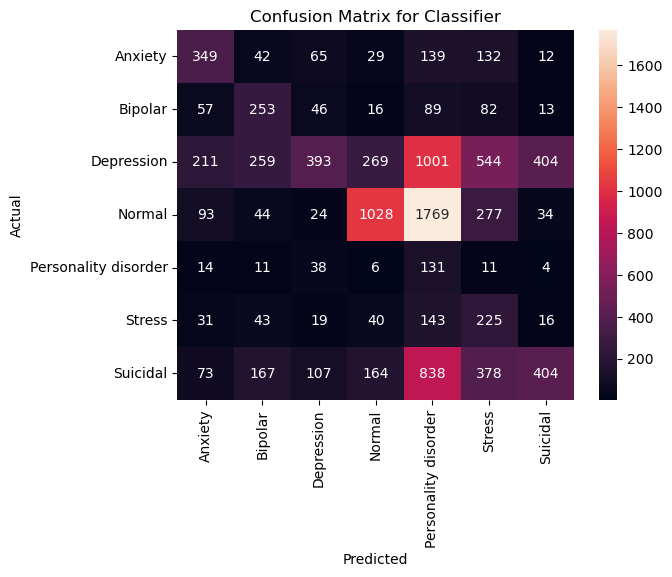

In [17]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Encoding target variable
encoder = LabelEncoder()
dfgrid['status_encoded'] = encoder.fit_transform(dfgrid['status']) 

# Features and target
X = dfgrid['clean']  # Text data (preprocessed)
y = dfgrid['status_encoded']  # Encoded target variable

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create the pipeline with TF-IDF vectorizer and classifier
gaus = Pipeline([
    ('vectorizer', TfidfVectorizer(max_features=5000, stop_words='english')),  # TF-IDF vectorization
    ('classifier', GaussianNB()),  # Gaussian Naive Bayes
])

# Train the model (convert sparse matrix to dense by using .toarray())
X_train_dense = gaus.named_steps['vectorizer'].fit_transform(X_train).toarray()
gaus.named_steps['classifier'].fit(X_train_dense, y_train)

# Transform test data and convert to dense format
X_test_dense = gaus.named_steps['vectorizer'].transform(X_test).toarray()

# Make predictions
y_pred = gaus.named_steps['classifier'].predict(X_test_dense)

# Evaluate the model
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy: {acc:.4f}')

# Confusion matrix and classification report
labels = encoder.classes_  # Use the original labels from encoder
conf_matrix = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred, target_names=labels))

# Plot confusion matrix as a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Classifier')
plt.show()


Accuracy: 0.6550
                      precision    recall  f1-score   support

             Anxiety       0.78      0.60      0.68       768
             Bipolar       0.88      0.46      0.60       556
          Depression       0.50      0.81      0.62      3081
              Normal       0.83      0.80      0.82      3269
Personality disorder       1.00      0.09      0.17       215
              Stress       0.74      0.07      0.12       517
            Suicidal       0.69      0.48      0.57      2131

            accuracy                           0.66     10537
           macro avg       0.78      0.47      0.51     10537
        weighted avg       0.71      0.66      0.64     10537



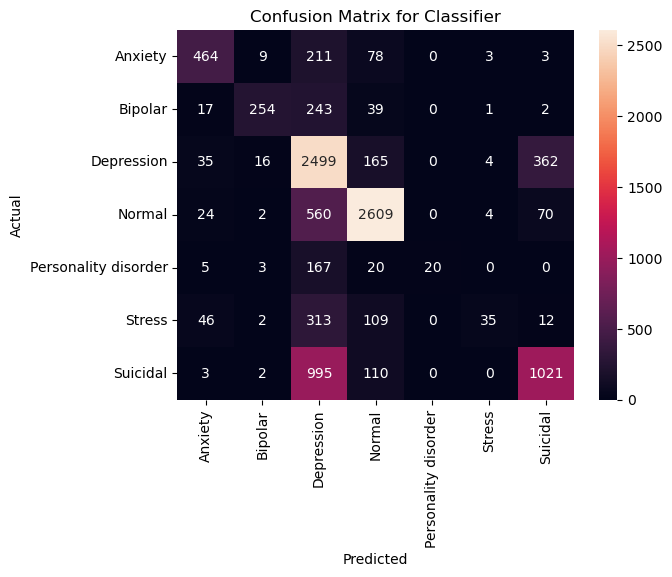

In [18]:
mul = Pipeline([
    ('vectorizer', TfidfVectorizer(max_features=5000, stop_words='english')),  # TF-IDF vectorization
    ('classifier', MultinomialNB()),
])

# Train the model
mul.fit(X_train, y_train)

# Make predictions
y_pred = mul.predict(X_test)

# Evaluate the model
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy: {acc:.4f}')

# Confusion matrix and classification report
labels = encoder.classes_  # Use the original labels from encoder
conf_matrix = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred, target_names=labels))

# Plot confusion matrix as a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Classifier')
plt.show()

Accuracy: 0.6092
                      precision    recall  f1-score   support

             Anxiety       0.69      0.55      0.61       768
             Bipolar       0.57      0.57      0.57       556
          Depression       0.69      0.39      0.50      3081
              Normal       0.64      0.93      0.76      3269
Personality disorder       0.34      0.56      0.43       215
              Stress       0.39      0.52      0.45       517
            Suicidal       0.56      0.49      0.52      2131

            accuracy                           0.61     10537
           macro avg       0.56      0.57      0.55     10537
        weighted avg       0.62      0.61      0.59     10537



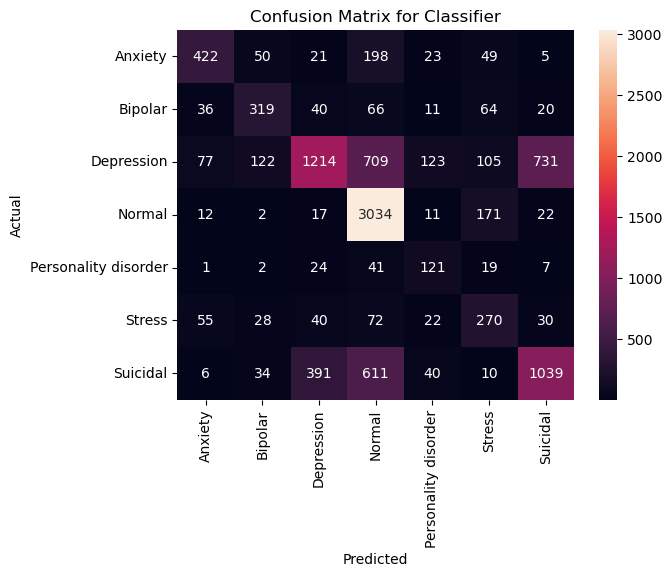

In [19]:
bern = Pipeline([
    ('vectorizer', TfidfVectorizer(max_features=5000, stop_words='english')),  # TF-IDF vectorization
    ('classifier', BernoulliNB()),
])

# Train the model
bern.fit(X_train, y_train)

# Make predictions
y_pred = bern.predict(X_test)

# Evaluate the model
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy: {acc:.4f}')

# Confusion matrix and classification report
labels = encoder.classes_  # Use the original labels from encoder
conf_matrix = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred, target_names=labels))

# Plot confusion matrix as a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Classifier')
plt.show()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.676013 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 265839
[LightGBM] [Info] Number of data points in the train set: 42144, number of used features: 4301
[LightGBM] [Info] Start training from score -2.618438
[LightGBM] [Info] Start training from score -2.943135
[LightGBM] [Info] Start training from score -1.229625
[LightGBM] [Info] Start training from score -1.170467
[LightGBM] [Info] Start training from score -3.889592
[LightGBM] [Info] Start training from score -3.013544
[LightGBM] [Info] Start training from score -1.598559
Accuracy: 0.7764
                      precision    recall  f1-score   support

             Anxiety       0.81      0.76      0.79       768
             Bipolar       0.87      0.79      0.83       556
          Depression       0.73      0.75      0.74      3081

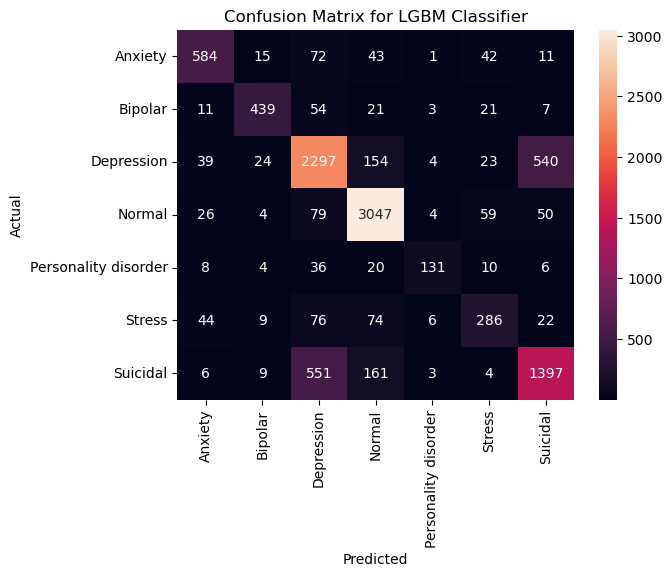

['pipe_model.pkl']

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# Data preparation: Encoding the target variable
encoder = LabelEncoder()
dfgrid['status_encoded'] = encoder.fit_transform(dfgrid['status']) 

# Features and target
X = dfgrid['clean']  # Text data (preprocessed)
y = dfgrid['status_encoded']  # Encoded target variable

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create the pipeline with TF-IDF vectorizer and classifier
pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(max_features=5000, stop_words='english')),  # TF-IDF vectorization
    ('classifier', LGBMClassifier()),
])

# Train the model
pipe.fit(X_train, y_train)

# Make predictions
y_pred = pipe.predict(X_test)

# Evaluate the model
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy: {acc:.4f}')

# Confusion matrix and classification report
labels = encoder.classes_  # Use the original labels from encoder
conf_matrix = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred, target_names=labels))

# Plot confusion matrix as a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for LGBM Classifier')
plt.show()

# model_dict = {'model': pipe, 'labels': encoder}
# joblib.dump(model_dict, 'pipe_model.pkl')

joblib.dump({'model':pipe,'labels':encoder}, 'pipe_model.pkl')

In [ ]:
# from sklearn.model_selection import GridSearchCV, train_test_split
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import accuracy_score
# x = dfgrid['clean'] 
# y = dfgrid['status'] 
# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)


# pipeline = Pipeline([
#     ('vectorizer', TfidfVectorizer(max_features=5000, stop_words='english')),  # Text vectorization
#     ('classifier', LGBMClassifier())  # LightGBM classifier
# ])

# Define the parameter grid for GridSearchCV to tune LightGBM's hyperparameters
# param_grid = {
#     'classifier__num_leaves': [31, 50, 100],  # Number of leaves in the tree
#     'classifier__max_depth': [-1, 10, 20],  # Maximum depth of trees (-1 means no limit)
#     'classifier__learning_rate': [0.05, 0.1, 0.2],  # Learning rate for boosting
#     'classifier__n_estimators': [20, 40, 100],  # Number of boosting iterations (trees)
#     'classifier__subsample': [0.7, 0.8, 1.0],  # Fraction of samples used for each tree
#     'classifier__colsample_bytree': [0.7, 0.8, 1.0]  # Fraction of features used for each tree
# }


# grid_search = GridSearchCV(pipeline, param_grid, cv=3, verbose=1, n_jobs=-1)

# grid_search.fit(X_train, y_train)


# print(f"Best parameters found: {grid_search.best_params_}")
# print(f"Best cross-validation accuracy: {grid_search.best_score_}")

# Use the best model found from GridSearchCV on the test set
# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(X_test)

# Evaluate the model's performance on the test set
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Test accuracy: {accuracy}")


# chatbot



In [50]:
import joblib
import re
import string
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from lightgbm import LGBMClassifier

# Initialize stopwords and stemmer
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

# Function to clean the input text
def clean_text(text):
    """Cleans the input text by removing unnecessary characters, stopwords, and applying stemming."""
    # Convert to lowercase and string
    text = str(text).lower()
    
    # Remove unwanted characters (URLs, square brackets, HTML tags, mentions, punctuation, etc.)
    text = re.sub(r'\[.*?\]', '', text)  # Remove text in square brackets
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>+', '', text)  # Remove HTML tags
    text = re.sub(r'@\w+', '', text)  # Remove @ mentions
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)  # Remove punctuation
    text = re.sub(r'\n', ' ', text)  # Remove newlines
    text = re.sub(r'\w*\d\w*', '', text)  # Remove words containing digits
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    text = text.strip()  # Remove leading and trailing spaces
    
    # Remove stopwords and apply stemming
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)  # Remove stopwords
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))  # Apply stemming
    
    return text

# Sample text input from the user
test_input = input("Enter text: ") 

# Clean the input text
cleaned_text = clean_text(test_input)

# Load the pre-trained model
loaded_pkl = joblib.load("pipe_model.pkl")
model = loaded_pkl['model']
label= loaded_pkl['labels']

prediction = model.predict([cleaned_text])

print(f"prediction: {prediction[0]}")

predicted_label = label.inverse_transform(prediction)

print(f"Predicted label: {predicted_label[0]}")


Enter text:  Why does the money have to be limited, if it's not limited there won't be a sick cat like this


prediction: 3
Predicted label: Normal


In [48]:
print(df['statement'].iloc[1000])
df['status'].iloc[1000]

Why does the money have to be limited, if it's not limited there won't be a sick cat like this


'Normal'